In [36]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import pandas as pd
import openturns as ot
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = True

# Paris' law basic forward Euler implementation

## Paris' Law

Paris' law is an empirical relationship that describes the rate of fatigue crack growth in materials. It is used to predict the growth of cracks under cyclic loading conditions. The law is expressed as:

$$ \frac{da}{dN} = C (\Delta K)^m $$

where:
- $ \frac{da}{dN} $ is the crack growth rate per cycle.
- $ C $ is a material constant.
- $ \Delta K $ is the stress intensity factor range.
- $ m $ is the Paris' law exponent.

### Parameters in this Notebook

- **Material constant (C):** $ 1 \times 10^{-10} $
- **Paris' law exponent (m):** 3.0
- **Maximum applied stress ($ \sigma_{max} $):** 100.0 MPa
- **Minimum applied stress ($ \sigma_{min} $):** 10.0 MPa
- **Geometry factor (Y):** 1.1
- **Initial crack length ($ a_0 $):** 0.001 meters
- **Total number of cycles (N_cycles):** 1,000,000
- **Step size (delta_N):** 1000 cycles per step
- **Critical crack length (a_max):** 0.05 meters

### Stress Intensity Factor Range (ΔK)

The stress intensity factor range, $ \Delta K $, is calculated using the formula:

$$ \Delta K = Y (\sigma_{max} - \sigma_{min}) \sqrt{\pi a} $$

where:
- $ Y $ is the geometry factor.
- $ \sigma_{max} $ is the maximum applied stress.
- $ \sigma_{min} $ is the minimum applied stress.
- $ a $ is the crack length.

This notebook will implement a basic forward Euler method to simulate the crack growth over the specified number of cycles.


In [37]:
# Function to compute ΔK
def delta_K(a, sigma_max, sigma_min, Y):
    return Y * (sigma_max - sigma_min) * np.sqrt(np.pi * a)

In [47]:
# Explicit Euler method for Paris' Law
def paris_crack_growth(a0, N_cycles, delta_N, C, m, sigma_max, sigma_min, Y, a_max):
    N_values = [0]  # Store cycle count
    a_values = [a0]  # Store crack lengths
    
    a = a0
    N = 0

    while N < N_cycles and a < a_max:
        # Compute stress intensity factor range
        dK = delta_K(a, sigma_max, sigma_min, Y)
        
        # Paris' law: da/dN = C * (ΔK)^m
        da_dN = C * (dK**m)
        
        # Explicit Euler update
        a_new = a + da_dN * delta_N
        N += delta_N

        # Stop if the crack length exceeds critical limit
        if a_new >= a_max:
            a_values.append(a_max)
            N_values.append(N)
            break

        # Store values       
        N_values.append(N)
        a_values.append(a_new)

        a = a_new

    return np.array(N_values), np.array(a_values)


In [48]:
crack = ot.Uniform(0.005, 0.02)
cycle = ot.Uniform(70000, 125000)


In [49]:
n_data = [3, 4, 2, 13]
data = [[np.sort(np.asarray(cycle.getSample(n_data[i])).reshape(-1)).astype(int), np.sort(np.asarray(crack.getSample(n_data[i])).reshape(-1))] for i in range(len(n_data))]

In [53]:
# Paris' law parameters (example values for a given material)
C = 1e-10  # Material constant (depends on units)
m = 3.0    # Paris' law exponent

# Load parameters
sigma_max = 100.0  # Maximum applied stress (MPa)
sigma_min = 10.0   # Minimum applied stress (MPa)
Y = 1.1  # Geometry factor (assumed constant)

# Initial conditions
a0 = 0.001  # Initial crack length in meters
N_cycles = 100e4  # Total number of cycles
delta_N = 1000  # Step size (number of cycles per step)
a_max = 0.05  # Critical crack length (instability point)


# Uncertainty propagation 

In [54]:
C_dist = ot.Uniform(C * 0.9, C * 1.1)  # Uniform distribution for C
m_dist = ot.Uniform(m - 0.1, m + 0.1)  # Uniform distribution for m
sigma_max_dist = ot.Uniform(sigma_max - 5.0, sigma_max + 5.0)  # Uniform distribution for sigma_max
sigma_min_dist = ot.Uniform(sigma_min - 1.0, sigma_min + 1.0)  # Uniform distribution for sigma_min
Y_dist = ot.Uniform(Y - 0.05, Y + 0.05)  # Uniform distribution for Y
a0_dist = ot.Uniform(a0 - 0.0001, a0 + 0.0001)  # Uniform distribution for a0

# Create a composed distribution
composed_distribution = ot.ComposedDistribution([C_dist, m_dist, sigma_max_dist, sigma_min_dist, Y_dist, a0_dist])

# Sample from the composed distribution
sample_size = 1000  # Define the sample size
samples = composed_distribution.getSample(sample_size)

# Display the first few samples
print(samples[:5])

    [ X0            X1            X2            X3            X4            X5            ]
0 : [   1.00478e-10   3.09161     104.993         9.28981       1.13429       0.00107776  ]
1 : [   1.08639e-10   3.01684      99.5836        9.73004       1.13782       0.0010499   ]
2 : [   1.00288e-10   2.95256     103.519         9.48544       1.13325       0.000976845 ]
3 : [   9.42048e-11   3.02454     104.549        10.0951        1.09563       0.00107376  ]
4 : [   1.06435e-10   3.04244     102.632         9.34284       1.06824       0.000918997 ]


Text(0, 0.5, 'Crack Length (m)')

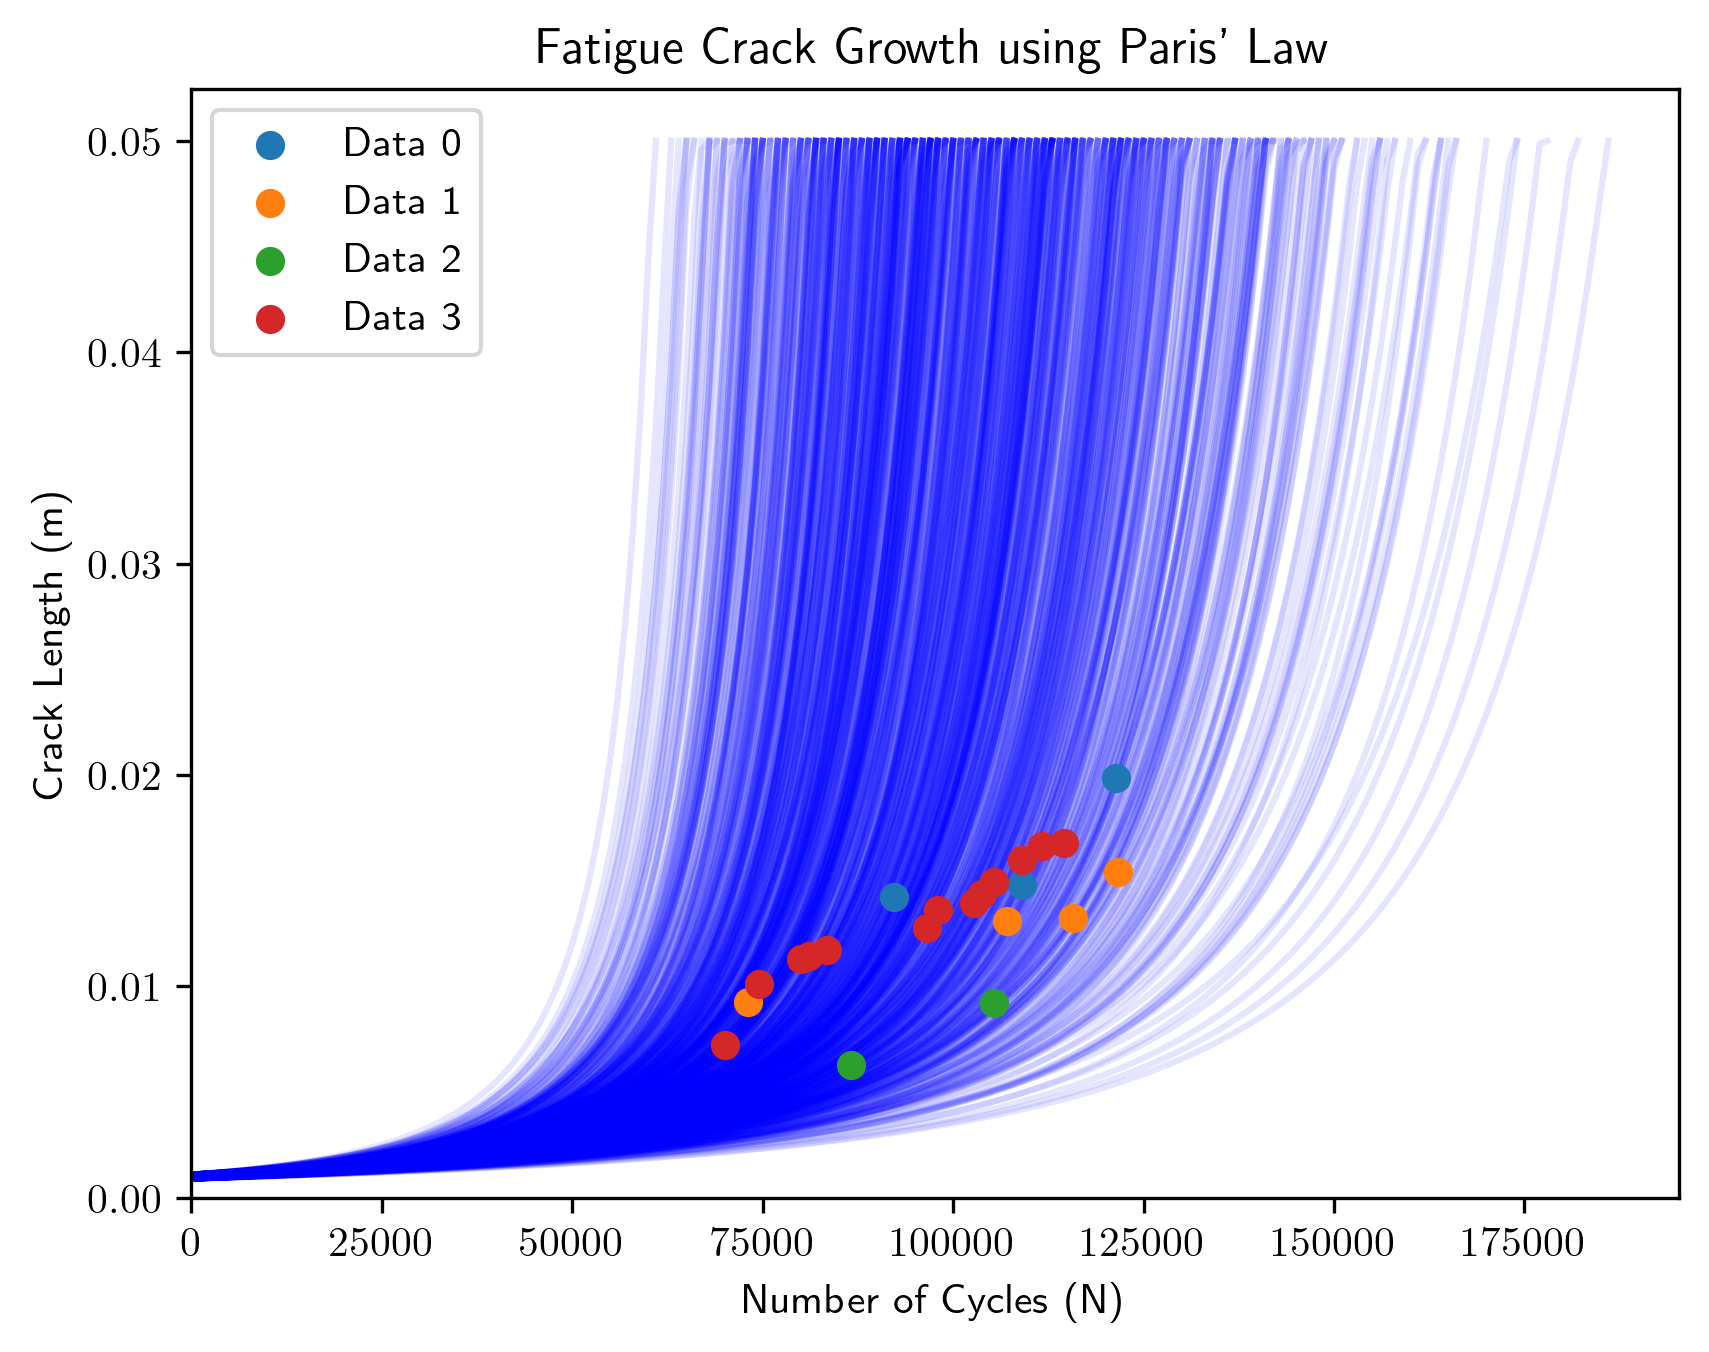

In [55]:
doe = []
for i in range(sample_size):
    C, m, sigma_max, sigma_min, Y, a0 = samples[i]
    N_values, a_values = paris_crack_growth(a0, N_cycles, delta_N, C, m, sigma_max, sigma_min, Y, a_max)
    doe.append([N_values, a_values])
    plt.plot(N_values, a_values, color='blue', alpha=0.1)
for i in range(len(data)):
    plt.scatter(data[i][0], data[i][1],  label=f'Data {i}', zorder=10)
plt.xlim(0)
plt.ylim(0)
plt.legend()
plt.title("Fatigue Crack Growth using Paris' Law")
plt.xlabel("Number of Cycles (N)")
plt.ylabel("Crack Length (m)")

In [56]:
doe[112][0].shape

(75,)

In [57]:
# Create a DataFrame from the data
data_dict = {}
for i in range(len(data)):
    data_dict['N_values'] = data[i][0]
    data_dict[f'Data {i}'] = data[i][1]


df = pd.DataFrame(data_dict)

# Save the DataFrame to a CSV file
df.to_csv('DATA/crack_data/crack_growth_data.csv', index=False)

ValueError: All arrays must be of the same length

# NASA Aluminium dataset
We could imitate the multifidelity setting by training different regression models.
Start with the feature extraction on the training dataset, use therefore T1-6 at different times to extract amplitude change, phase angle change, correlation coefficient change, as is done in the paper by Peng et. al 2014. 

## Feature extraction

In [294]:
# Load data copied from the excel tables
cycles_t1 = [50000, 60000, 62500, 65500, 69025, 70026, 70766]
crack_size_t1 = [0, 2.18, 2.76, 3.51, 4.51, 4.9, 7.46]

cycles_t2 = [50000, 70033, 72000]
crack_size_t2 = [0, 3.25, 4.95]

cycles_t3 = [14000, 50000, 57038, 60035, 62017, 64019, 65029, 66012, 66510]
crack_size_t3 = [0, 0, 2.57, 4.02, 4.72, 5.49, 5.9, 6.52, 6.93]

cycles_t4 = [55900, 60200, 65001, 67054, 70016, 71130, 73210, 75045]
crack_size_t4 = [0, 1.61, 2.17, 2.74, 3.13, 4.06, 4.96, 7.24]

cycles_t5 = [42000, 46000, 51000, 56000]
crack_size_t5 = [0, 0, 2.7, 3.64]


In [295]:
T1 = {cycles_t1[i]: {'crack_size': crack_size_t1[i]} for i in range(len(cycles_t1))}
T2 = {cycles_t2[i]: {'crack_size': crack_size_t2[i]} for i in range(len(cycles_t2))}
T3 = {cycles_t3[i]: {'crack_size': crack_size_t3[i]} for i in range(len(cycles_t3))}
T4 = {cycles_t4[i]: {'crack_size': crack_size_t4[i]} for i in range(len(cycles_t4))}
T5 = {cycles_t5[i]: {'crack_size': crack_size_t5[i]} for i in range(len(cycles_t5))}

In [296]:
train_data = [T1, T2, T3, T4, T5]

In [297]:
BASE_DIRECTORY = '/Users/edgarjaber/Desktop/Articles/codes folder/Bayes-calibration-for-clogging-prognostics/DATA/NASA_crack_growth_data/'

In [298]:
for i in range(len(train_data)):
    for j in range(len(train_data[i].keys())):
        try:
            csv_file = BASE_DIRECTORY + f'training/T{(i+1)}/' +  str(list(train_data[i].keys())[j]) + '/signal_1.csv'
            train_data[i][list(train_data[i].keys())[j]]['signal1'] = pd.read_csv(csv_file)
        except:
            pass

In [299]:
fs = 200 #Hz

IndexError: list index out of range

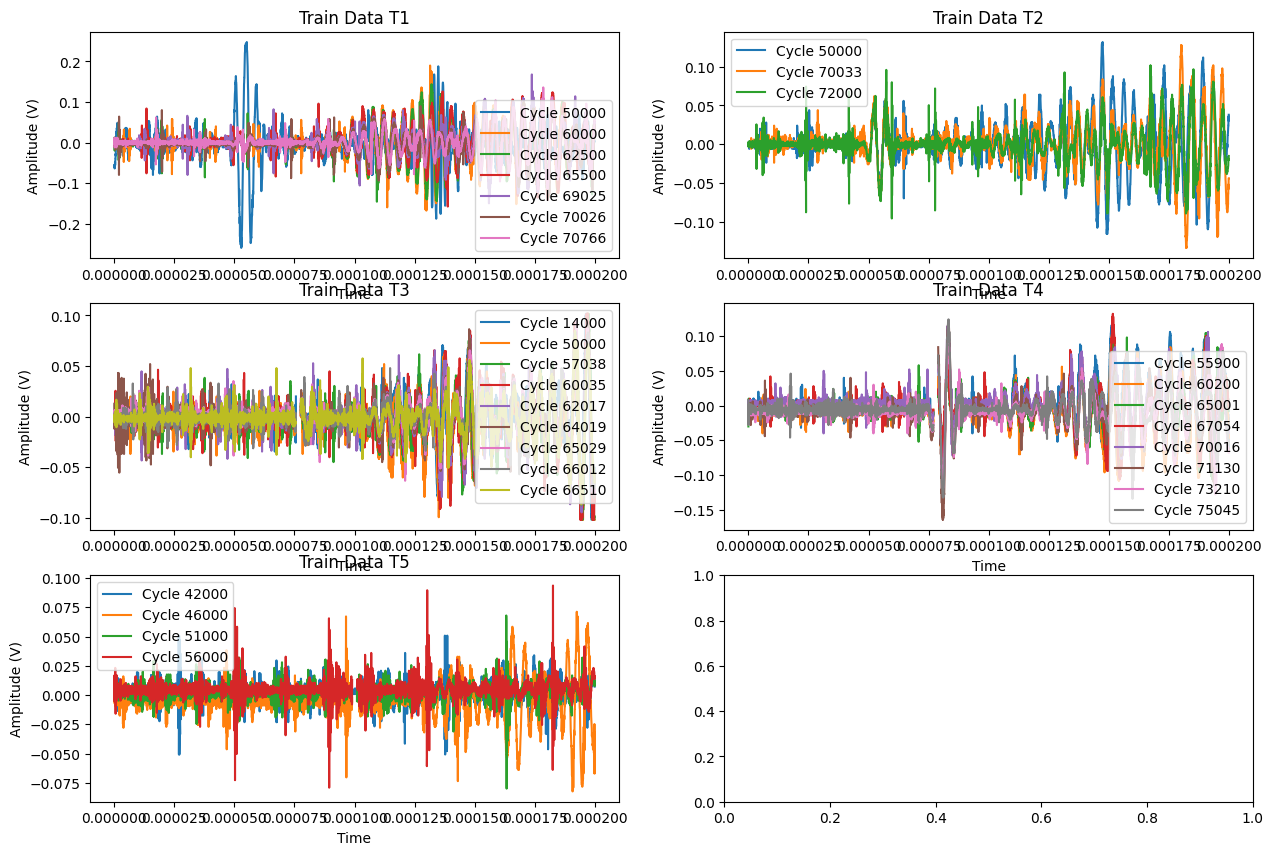

In [300]:
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
# Filter the signal

for i, ax in enumerate(axs.flatten()):
    for cycle, data in train_data[i].items():
        if 'signal1' in data:
            ax.plot(data['signal1']['time'],data['signal1']['ch2'], label=f'Cycle {cycle}')
    ax.set_title(f'Train Data T{i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude (V)')
    #ax.set_xlim(105e-6, 125e-6)
    ax.legend()

plt.tight_layout()
plt.show()

In [301]:
# Extract the time values from the signal
time_values = data['signal1']['time'].values

# Calculate the time difference between consecutive samples
time_diff = np.diff(time_values)

# Calculate the sampling frequency
sampling_frequency = 1 / np.mean(time_diff)
print(f"Sampling Frequency: {sampling_frequency} Hz")

Sampling Frequency: nan Hz


In [302]:
freq = 200e3  # 200 kHz central frequency
fs = 200e3

In [303]:
# 1. Amplitude Change Extraction
def extract_amplitude_change(baseline, damaged):
    """Computes the normalized amplitude change."""
    env_baseline = np.abs(signal.hilbert(baseline))
    env_damaged = np.abs(signal.hilbert(damaged))
    amplitude_norm = np.mean(env_damaged) / np.mean(env_baseline)
    amplitude_change = 1 - amplitude_norm
    return amplitude_change

# 2. Phase Change Extraction
def extract_phase_change(baseline, damaged):
    """Computes phase shift using cross-correlation."""
    corr = signal.correlate(damaged, baseline, mode='full')
    shift = np.argmax(corr) - len(baseline)  # Find the peak shift
    phase_change = shift / fs * 360 * freq  # Convert to degrees
    return phase_change

# 3. Correlation Coefficient Change Extraction
def extract_correlation_change(baseline, damaged):
    """Computes the correlation coefficient between baseline and damaged signals."""
    correlation_coeff = np.corrcoef(baseline, damaged)[0, 1]
    return correlation_coeff


In [304]:
for i in range(len(train_data)):
    baseline_signal = train_data[i][list(train_data[i].keys())[0]]['signal1']['ch2'].values

    train_data[i][list(train_data[i].keys())[0]]['amplitude_change'] = 0
    train_data[i][list(train_data[i].keys())[0]]['phase_change'] = 0
    train_data[i][list(train_data[i].keys())[0]]['correlation_change'] = 0
    
    for j in range(len(train_data[i].keys())-1):
        damaged_signal = train_data[i][list(train_data[i].keys())[j+1]]['signal1']['ch2'].values

        amplitude_change = extract_amplitude_change(baseline_signal, damaged_signal)
        phase_change = extract_phase_change(baseline_signal, damaged_signal)
        correlation_change = extract_correlation_change(baseline_signal, damaged_signal)

        print(f"Amplitude Change: {amplitude_change}")
        print(f"Phase Change: {phase_change}")
        print(f"Correlation Change: {correlation_change}")

        train_data[i][list(train_data[i].keys())[j+1]]['amplitude_change'] = amplitude_change
        train_data[i][list(train_data[i].keys())[j+1]]['phase_change'] = phase_change
        train_data[i][list(train_data[i].keys())[j+1]]['correlation_change'] = correlation_change

Amplitude Change: -0.07881869894703719
Phase Change: 554400.0
Correlation Change: -0.07071919981273783
Amplitude Change: -0.030084161534794207
Phase Change: 555840.0
Correlation Change: -0.06648296510513747
Amplitude Change: -0.023644530545420706
Phase Change: 919440.0
Correlation Change: -0.0653767744668491
Amplitude Change: 0.15331601476562384
Phase Change: 888480.0
Correlation Change: -0.061975169162460646
Amplitude Change: 0.25274711286773477
Phase Change: 889560.0
Correlation Change: -0.07606170179140363
Amplitude Change: 0.3283574543602793
Phase Change: 918000.0
Correlation Change: -0.1023311346439405
Amplitude Change: 0.1277150106285695
Phase Change: 1080.0
Correlation Change: 0.5320574463793943
Amplitude Change: 0.29115149409640095
Phase Change: 1440.0000000000002
Correlation Change: 0.4950727086975983
Amplitude Change: -0.1887829063343507
Phase Change: 2519.9999999999995
Correlation Change: 0.7123176379993109
Amplitude Change: -0.19160801137004446
Phase Change: 3600.0000000000

In [350]:
#Normalize the features
scaler = MinMaxScaler()
X_train = np.array([[train_data[i][key]['amplitude_change'], train_data[i][key]['phase_change'], train_data[i][key]['correlation_change']] for i in range(len(train_data)) for key in train_data[i].keys()])
X_train = scaler.fit_transform(X_train)

In [351]:
y_train = np.asarray([train_data[i][key]['crack_size'] for i in range(len(train_data)) for key in train_data[i].keys()])

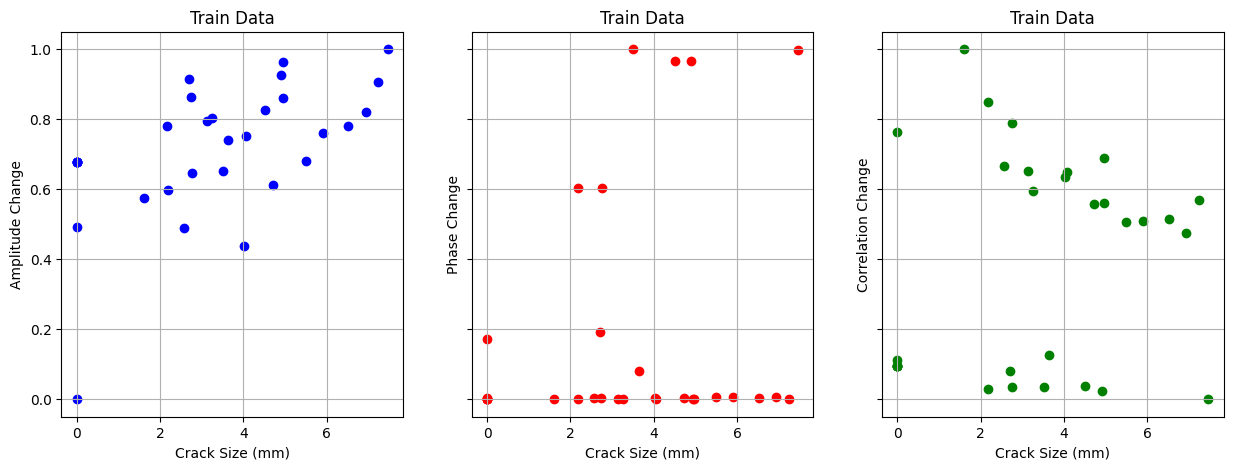

In [352]:
# Display the extracted features correlation with the crack size
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

axs[0].scatter(y_train, X_train[:, 0], color='blue')
axs[0].set_xlabel('Crack Size (mm)')
axs[0].set_ylabel('Amplitude Change')
axs[0].set_title(f'Train Data')
axs[0].grid(True)

axs[1].scatter(y_train,  X_train[:, 1], color='red')
axs[1].set_xlabel('Crack Size (mm)')
axs[1].set_ylabel('Phase Change')
axs[1].set_title(f'Train Data')
axs[1].grid(True)

axs[2].scatter(y_train,  X_train[:, 2], color='green')
axs[2].set_xlabel('Crack Size (mm)')
axs[2].set_ylabel('Correlation Change')
axs[2].set_title(f'Train Data')
axs[2].grid(True)    

## Validation set

In [326]:
# Validation data
cycles_t6 = [55000, 60078, 68091, 69018, 72516, 73211]
crack_size_t6 = [0, 0.82, 2.36, 3.36, 4.65, 5.08]

cycles_t7 = [36001, 40167, 44054, 47022]
crack_size_t7 = [0, 2.07, 3.14, 3.56]


In [327]:
T6 = {cycles_t6[i]: {'crack_size': crack_size_t6[i]} for i in range(len(cycles_t6))}
T7 = {cycles_t7[i]: {'crack_size': crack_size_t7[i]} for i in range(len(cycles_t7))}

In [328]:
validation_data = [T6, T7]

In [329]:
for i in range(len(validation_data)):
    for j in range(len(validation_data[i].keys())):
        try:
            csv_file = BASE_DIRECTORY + f'validation/T{(i+6)}/' +  str(list(validation_data[i].keys())[j]) + '/signal_1.csv'
            validation_data[i][list(validation_data[i].keys())[j]]['signal1'] = pd.read_csv(csv_file)
        except:
            pass

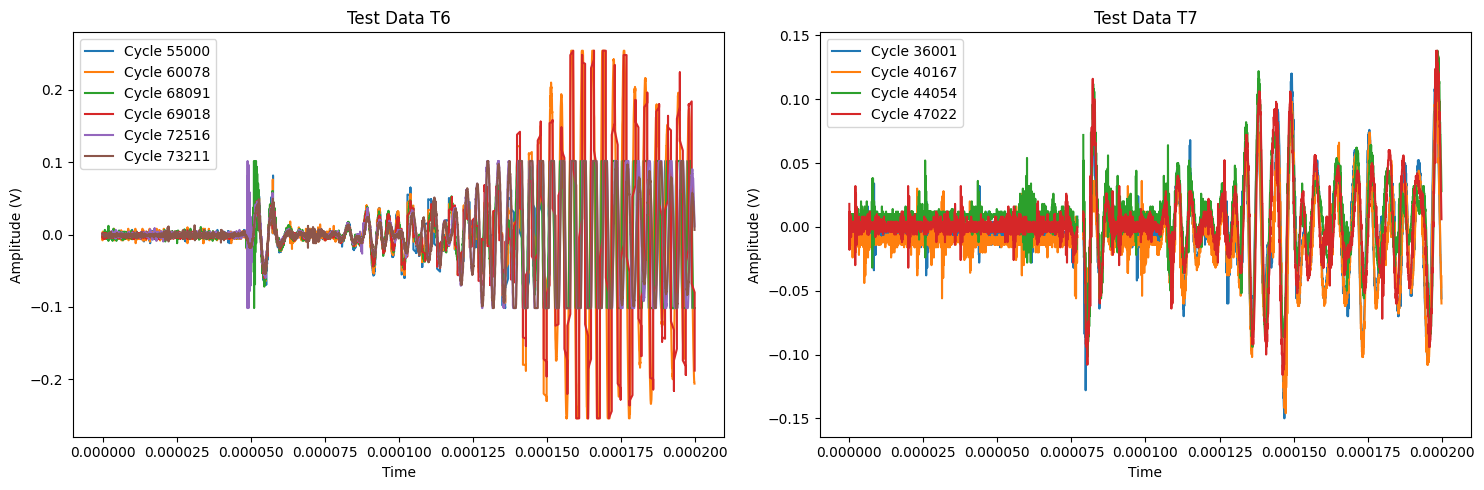

In [330]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Filter the signal

for i, ax in enumerate(axs.flatten()):
    for cycle, data in validation_data[i].items():
        if 'signal1' in data:
            ax.plot(data['signal1']['time'],data['signal1']['ch2'], label=f'Cycle {cycle}')
    ax.set_title(f'Test Data T{i+6}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude (V)')
    #ax.set_xlim(105e-6, 125e-6)
    ax.legend()

plt.tight_layout()
plt.show()

In [331]:
for i in range(len(validation_data)):
    baseline_signal = validation_data[i][list(validation_data[i].keys())[0]]['signal1']['ch2'].values

    validation_data[i][list(validation_data[i].keys())[0]]['amplitude_change'] = 0
    validation_data[i][list(validation_data[i].keys())[0]]['phase_change'] = 0
    validation_data[i][list(validation_data[i].keys())[0]]['correlation_change'] = 0

    
    for j in range(len(validation_data[i].keys())-1):
        damaged_signal = validation_data[i][list(validation_data[i].keys())[j+1]]['signal1']['ch2'].values

        amplitude_change = extract_amplitude_change(baseline_signal, damaged_signal)
        phase_change = extract_phase_change(baseline_signal, damaged_signal)
        correlation_change = extract_correlation_change(baseline_signal, damaged_signal)

        print(f"Amplitude Change: {amplitude_change}")
        print(f"Phase Change: {phase_change}")
        print(f"Correlation Change: {correlation_change}")

        validation_data[i][list(validation_data[i].keys())[j+1]]['amplitude_change'] = amplitude_change
        validation_data[i][list(validation_data[i].keys())[j+1]]['phase_change'] = phase_change
        validation_data[i][list(validation_data[i].keys())[j+1]]['correlation_change'] = correlation_change

Amplitude Change: -0.49189708351094663
Phase Change: 0.0
Correlation Change: 0.9305126450718956
Amplitude Change: 0.016909393308926712
Phase Change: 720.0000000000001
Correlation Change: 0.8544070693740471
Amplitude Change: -0.4173640080834704
Phase Change: 1800.0000000000002
Correlation Change: 0.747803474299745
Amplitude Change: -0.0009233325669031345
Phase Change: -150840.0
Correlation Change: 0.13723691872737592
Amplitude Change: 0.08256511675436051
Phase Change: -150480.0
Correlation Change: 0.0852428943920519
Amplitude Change: -0.022226009083535114
Phase Change: 0.0
Correlation Change: 0.9471614026806071
Amplitude Change: 0.04579980441350495
Phase Change: 1080.0
Correlation Change: 0.7226575266193133
Amplitude Change: 0.05776427089243841
Phase Change: 360.00000000000006
Correlation Change: 0.7219880196228206


In [332]:
#Normalize the features
scaler = StandardScaler()
X_test = np.array([[validation_data[i][key]['amplitude_change'], validation_data[i][key]['phase_change'], validation_data[i][key]['correlation_change']] for i in range(len(validation_data)) for key in validation_data[i].keys()])
X_test = scaler.fit_transform(X_test)

In [333]:
y_test = np.asarray([validation_data[i][key]['crack_size'] for i in range(len(validation_data)) for key in validation_data[i].keys()])

In [334]:
y_test

array([0.  , 0.82, 2.36, 3.36, 4.65, 5.08, 0.  , 2.07, 3.14, 3.56])

In [338]:
X_test

array([[ 0.3761502 ,  0.49179179, -1.34124988],
       [-2.16065164,  0.49179179,  1.08355595],
       [ 0.46335498,  0.50369958,  0.88523383],
       [-1.77627115,  0.52156127,  0.60743747],
       [ 0.3713884 , -2.00289054, -0.98362671],
       [ 0.80195337, -1.99693664, -1.11911698],
       [ 0.3761502 ,  0.49179179, -1.34124988],
       [ 0.26152666,  0.49179179,  1.12694064],
       [ 0.61234803,  0.50965348,  0.54191011],
       [ 0.67405094,  0.49774569,  0.54016545]])

## Linear model

In [335]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [339]:
model.coef_

array([1.09827112, 0.89619237, 0.94533336])